In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Data Exploration

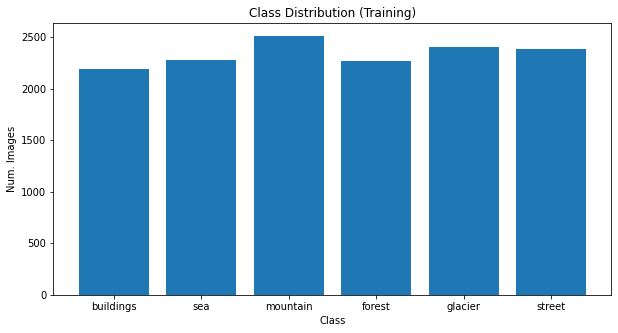

In [3]:
#Distribution of images per class in training
train_path = "/scratch/cl3578/dl_project/seg_train/seg_train"
class_lists = os.listdir(train_path)
num_classes = len(class_lists)
num_imgs_list = []
for c in class_lists:
    temp_path = train_path+"/"+c
    num_imgs = len(os.listdir(temp_path))
    num_imgs_list.append(num_imgs)
plt.figure(figsize=(10,5))
plt.bar(range(num_classes), num_imgs_list)
plt.xticks(range(num_classes), class_lists)
plt.xlabel("Class")
plt.ylabel("Num. Images")
plt.title("Class Distribution (Training)")
plt.show()

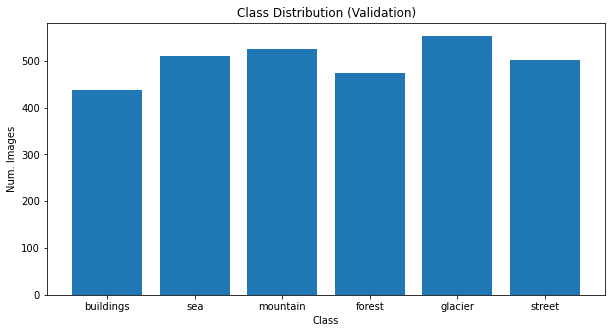

In [4]:
#Distribution of images per class in test
test_path = "/scratch/cl3578/dl_project/seg_test/seg_test"
num_imgs_list = []
for c in class_lists:
    temp_path = test_path+"/"+c
    num_imgs = len(os.listdir(temp_path))
    num_imgs_list.append(num_imgs)
plt.figure(figsize=(10,5))
plt.bar(range(num_classes), num_imgs_list)
plt.xticks(range(num_classes), class_lists)
plt.xlabel("Class")
plt.ylabel("Num. Images")
plt.title("Class Distribution (Validation)")
plt.show()

# Loading Data

In [5]:
BATCH_SIZE = 64

train_path = "/scratch/cl3578/dl_project/seg_train/seg_train/"
test_path = "/scratch/cl3578/dl_project/seg_test/seg_test/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path, batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path, batch_size=BATCH_SIZE)

class_names = train_ds.class_names

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
#configure dataset for performance
AUTO = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTO)
test_ds = test_ds.prefetch(AUTO)

# Visualizing Sample Images

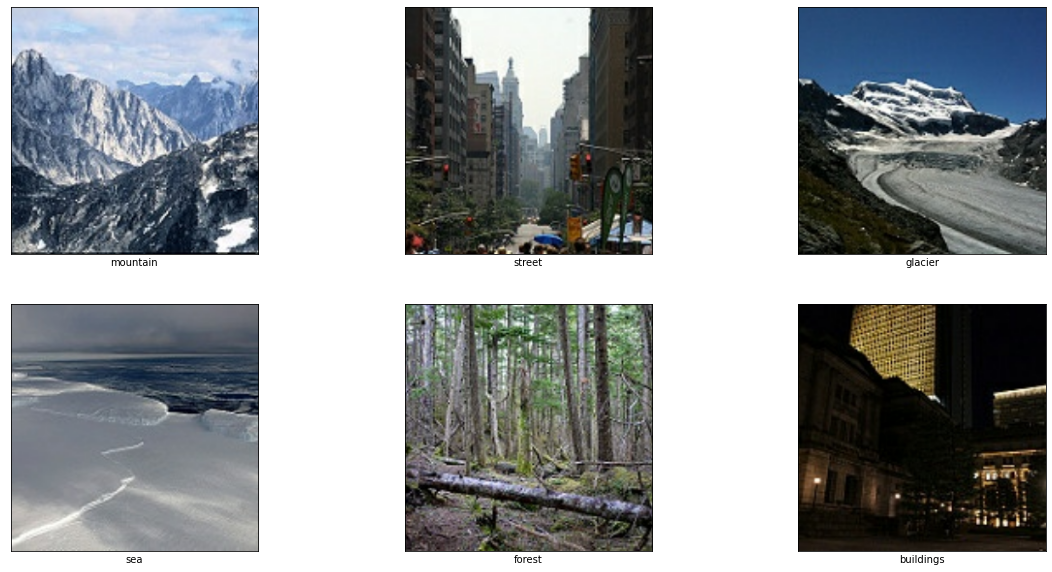

In [7]:
plt.figure(figsize=(20,10))
avail_class_name = class_lists[:]
for imgs, labels in train_ds.take(1):
    i = 0
    img_iter = 0
    while len(avail_class_name)!=0:
        current_label = class_names[labels[img_iter]]
        if current_label in avail_class_name:
            plt.subplot(2,3,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[img_iter].numpy().astype("uint8"))
            plt.xlabel(class_names[labels[img_iter]])
            i += 1
            avail_class_name.remove(current_label)
        img_iter += 1
    plt.show()

# Transfer Learning

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_model_acc(train_acc, val_acc):
    print("Final Train Accuracy: ", train_acc[-1])
    print("Final Validation Accuracy: ", val_acc[-1])
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

def plot_train_and_val_acc(acc, val_acc, initial_epochs = 50):
    plt.plot(acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()
    
def plot_cm(y_test, y_pred, labels):
    confusion = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion, display_labels=labels)
    disp.plot()

def generate_report(clf, test_ds, class_names):
    print(class_names)
    y_test = []
    y_pred = []
    for imgs, labels in test_ds.take(-1):
        actual_labels = labels.numpy()
        pred = clf.predict_on_batch(imgs)
        pred = np.argmax(pred, axis=-1)
        actual_labels = list(actual_labels)
        pred = list(pred)
        y_test+=actual_labels
        y_pred+=pred
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    #print("Actual: ", y_test[:20])
    #print("Pred: ", y_pred[:20])
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_cm(y_test, y_pred, class_names)

## Xception

In [9]:
def get_xception(input_shape, finetune = False, is_base = False):
    preprocess_input = tf.keras.applications.xception.preprocess_input
    
    base_model = None
    
    if is_base:
        base_model = tf.keras.applications.Xception(input_shape = input_shape,
                                                    include_top = False,
                                                    pooling = "avg")
    else:
        base_model = tf.keras.applications.Xception(input_shape = input_shape,
                                                    include_top = False,
                                                    weights = "imagenet",
                                                    pooling = "avg")
    base_model.trainable = finetune
    
    inputs = tf.keras.Input(shape = input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [13]:
#Test
my_model = get_xception((256,256, 3))
print(my_model.layers[3].name)
#my_model.summary()

xception


### Base Model

In [86]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_xception = get_xception(img_shape, finetune = True, is_base = True)
    base_xception.compile(loss = 'sparse_categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ['accuracy'])
start = time.time()
history = base_xception.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data = test_ds,
                            verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 124s 474ms/step - loss: 0.4597 - accuracy: 0.8460 - val_loss: 1.0082 - val_accuracy: 0.6823
Epoch 2/100
220/220 [==============================] - 102s 463ms/step - loss: 0.2116 - accuracy: 0.9269 - val_loss: 0.3383 - val_accuracy: 0.8857
Epoch 3/100
220/220 [==============================] - 102s 463ms/step - loss: 0.1793 - accuracy: 0.9379 - val_loss: 0.8290 - val_accuracy: 0.7913
Epoch 4/100
220/220 [==============================] - 102s 463ms/step - loss: 0.1391 - accuracy: 0.9494 - val_loss: 0.4602 - val_accuracy: 0.8540
Epoch 5/100
220/220 [==============================] - 102s 461ms/step - loss: 0.1141 - accuracy: 0.9636 - val_loss: 0.7483 - val_accuracy: 0.8333
Epoch 6/100
220/220 [==============================] - 102s 461ms/step - loss: 0.0861 - accuracy: 0.9704 - val_loss:

Final Train Accuracy:  0.9923756718635559
Final Validation Accuracy:  0.918666660785675


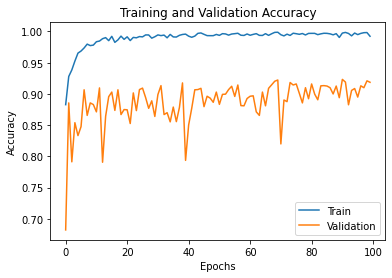

In [87]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [88]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [89]:
base_xception.save("./xception_base")

INFO:tensorflow:Assets written to: ./xception_base/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.91       437
      forest       0.98      0.99      0.99       474
     glacier       0.90      0.85      0.88       553
    mountain       0.86      0.90      0.88       525
         sea       0.96      0.93      0.94       510
      street       0.90      0.95      0.92       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



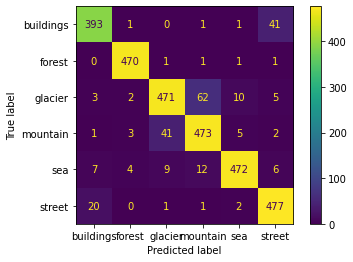

In [90]:
generate_report(base_xception, test_ds, class_names)

### Feature Extract

In [11]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fe_xception = get_xception(img_shape)
    fe_xception.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

start = time.time()
history = fe_xception.fit(train_ds,
                          epochs=EPOCHS,
                          validation_data = test_ds,
                          verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
220/220 [==============================] - 202s 895ms/step - loss: 0.6702 - accuracy: 0.7891 - val_loss: 0.2712 - val_accuracy: 0.9023
Epoch 2/100
220/220 [==============================] - 20s 89ms/step - loss: 0.2489 - accuracy: 0.9099 - val_loss: 0.2485 - val_accuracy: 0.9057
Epoch 3/100
220/220 [==============================] - 20s 89ms/step - loss: 0.2226 - accuracy: 0.9173 - val_loss: 0.2358 - val_accuracy: 0.9093
Epoch 4/100
220/220 [==============================] - 20s 87ms/step - loss: 0.2089 - accuracy: 0.9205 - val_loss: 0.2291 - val_accuracy: 0.9133
Epoch 5/100
220/220 [==============================] - 20s 88ms/step - loss: 0.1957 - accuracy: 0.9

Epoch 55/100
220/220 [==============================] - 21s 93ms/step - loss: 0.0812 - accuracy: 0.9737 - val_loss: 0.2542 - val_accuracy: 0.9183
Epoch 56/100
220/220 [==============================] - 20s 89ms/step - loss: 0.0788 - accuracy: 0.9762 - val_loss: 0.2566 - val_accuracy: 0.9183
Epoch 57/100
220/220 [==============================] - 20s 87ms/step - loss: 0.0785 - accuracy: 0.9767 - val_loss: 0.2653 - val_accuracy: 0.9163
Epoch 58/100
220/220 [==============================] - 20s 88ms/step - loss: 0.0807 - accuracy: 0.9749 - val_loss: 0.2607 - val_accuracy: 0.9180
Epoch 59/100
220/220 [==============================] - 20s 88ms/step - loss: 0.0776 - accuracy: 0.9753 - val_loss: 0.2614 - val_accuracy: 0.9153
Epoch 60/100
220/220 [==============================] - 20s 87ms/step - loss: 0.0768 - accuracy: 0.9772 - val_loss: 0.2623 - val_accuracy: 0.9167
Epoch 61/100
220/220 [==============================] - 20s 87ms/step - loss: 0.0761 - accuracy: 0.9773 - val_loss: 0.2627 -

Final Train Accuracy:  0.9838249683380127
Final Validation Accuracy:  0.9136666655540466


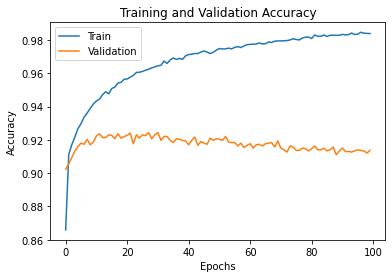

In [12]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [13]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [14]:
fe_xception.save("./xception_fe")

INFO:tensorflow:Assets written to: ./xception_fe/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.91      0.89      0.90       437
      forest       0.98      0.99      0.99       474
     glacier       0.90      0.82      0.86       553
    mountain       0.84      0.88      0.86       525
         sea       0.95      0.97      0.96       510
      street       0.91      0.93      0.92       501

    accuracy                           0.91      3000
   macro avg       0.92      0.92      0.91      3000
weighted avg       0.91      0.91      0.91      3000



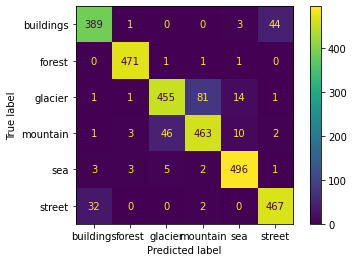

In [17]:
generate_report(fe_xception, test_ds, class_names)

### Finetune

In [18]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    f_xception = get_xception(img_shape, finetune=True)
    f_xception.compile(loss = 'sparse_categorical_crossentropy',
                       optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                       metrics = ['accuracy'])

start = time.time()
history = f_xception.fit(train_ds,
                         epochs=EPOCHS,
                         validation_data = test_ds,
                         verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
220/220 [==============================] - 126s 476ms/step - loss: 0.5653 - accuracy: 0.8194 - val_loss: 0.1806 - val_accuracy: 0.9373
Epoch 2/100
220/220 [==============================] - 102s 461ms/step - loss: 0.1157 - accuracy: 0.9619 - val_loss: 0.2252 - val_accuracy: 0.9313
Epoch 3/100
220/220 [==============================] - 102s 462ms/step - loss: 0.0523 - accuracy: 0.9833 - val_loss: 0.2247 - val_accuracy: 0.9387
Epoch 4/100
220/220 [==============================] - 102s 462ms/step - loss: 0.0241 - accuracy: 0.9936 - val_loss: 0.2434 - val_accuracy: 0.9430
Epoch 5/100
220/220 [==============================] - 102s 462ms/step - loss: 0.0157 - a

Final Train Accuracy:  0.9987174272537231
Final Validation Accuracy:  0.9399999976158142


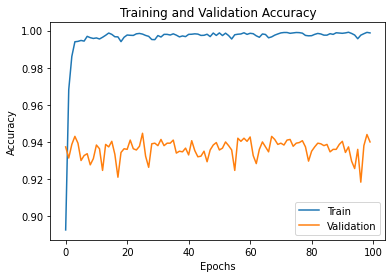

In [19]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [20]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [21]:
f_xception.save("./xception_f")

INFO:tensorflow:Assets written to: ./xception_f/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.94       437
      forest       0.99      0.99      0.99       474
     glacier       0.91      0.89      0.90       553
    mountain       0.90      0.92      0.91       525
         sea       0.96      0.97      0.97       510
      street       0.94      0.95      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



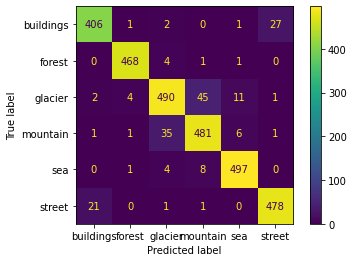

In [22]:
generate_report(f_xception, test_ds, class_names)

### Feature Extract + Finetune

In [23]:
EPOCHS = 50
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fef_xception = get_xception(img_shape)
    fef_xception.compile(loss = 'sparse_categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

fe_start = time.time()
history = fef_xception.fit(train_ds,
                           epochs=EPOCHS,
                           validation_data = test_ds,
                           verbose=1)
fe_total = time.time() - fe_start

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
220/220 [==============================] - 28s 99ms/step - loss: 0.6727 - accuracy: 0.7930 - val_loss: 0.2724 - val_accuracy: 0.8997
Epoch 2/50
220/220 [==============================] - 19s 86ms/step - loss: 0.2520 - accuracy: 0.9097 - val_loss: 0.2438 - val_accuracy: 0.9103
Epoch 3/50
220/220 [==============================] - 20s 87ms/step - loss: 0.2216 - accuracy: 0.9204 - val_loss: 0.2354 - val_accuracy: 0.9107
Epoch 4/50
220/220 [==============================] - 20s 87ms/step - loss: 0.2070 - accuracy: 0.9244 - val_loss: 0.2298 - val_accuracy: 0.9117
Epoch 5/50
220/220 [==============================] - 20s 87ms/step - loss: 0.1960 - accuracy: 0.9280 - v

Final Train Accuracy:  0.9742767810821533
Final Validation Accuracy:  0.9133333563804626


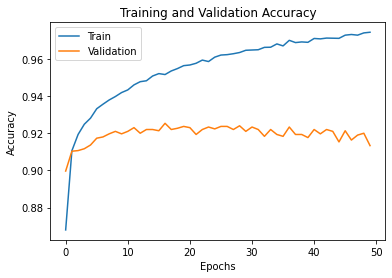

In [24]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
with strategy.scope():
    fef_xception.layers[3].trainable = True #mark it as trainable
    fef_xception.compile(loss = 'sparse_categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(lr=0.0001), #making minor adjustments to the network
                         metrics = ['accuracy'])
    
    
total_epochs = EPOCHS + EPOCHS

f_start = time.time()
history = fef_xception.fit(train_ds,
                           epochs=total_epochs,
                           initial_epoch=history.epoch[-1],
                           validation_data = test_ds,
                           verbose=1)
f_total = time.time() - f_start
print("Total Time (Training): ", fe_total + f_total)

Epoch 50/100
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
220/220 [==============================] - 124s 474ms/step - loss: 0.3495 - accuracy: 0.8814 - val_loss: 0.2312 - val_accuracy: 0.9267
Epoch 51/100
220/220 [==============================] - 102s 463ms/step - loss: 0.0793 - accuracy: 0.9719 - val_loss: 0.2604 - val_accuracy: 0.9310
Epoch 52/100
220/220 [==============================] - 102s 463ms/step - loss: 0.0408 - accuracy: 0.9859 - val_loss: 0.3247 - val_accuracy: 0.9250
Epoch 53/100
220/220 [==============================] - 103s 465ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.3599 - val_accuracy: 0.9243
Epoch 54/100
220/220 [==============================] - 102s 462ms/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.3675 - val_accuracy: 0.9253
Epoch 55/100
220/220 [==============================] - 102s 463ms/step - loss: 0.0178

Final Train Accuracy:  0.9975060820579529
Final Validation Accuracy:  0.9359999895095825


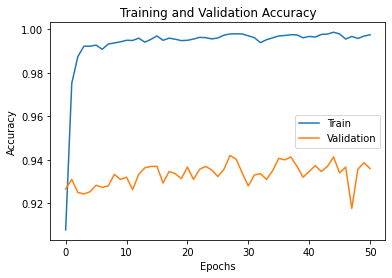

In [26]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

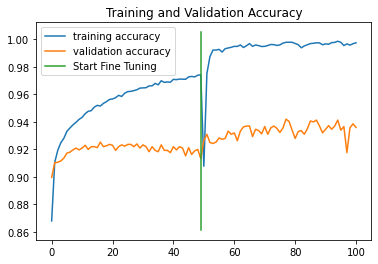

In [27]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
plot_train_and_val_acc(acc, val_acc, EPOCHS)

In [28]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [29]:
fef_xception.save("./xception_fef")

INFO:tensorflow:Assets written to: ./xception_fef/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.94      0.85      0.89       553
    mountain       0.88      0.93      0.90       525
         sea       0.95      0.99      0.97       510
      street       0.93      0.95      0.94       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



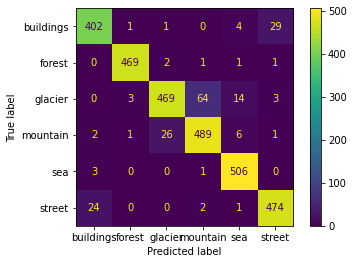

In [30]:
generate_report(fef_xception, test_ds, class_names)

## InceptionV3

In [31]:
def get_inceptionv3(input_shape, finetune = False, is_base = False):
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    
    base_model = None
    if is_base:
        base_model = tf.keras.applications.InceptionV3(input_shape = input_shape,
                                                       include_top = False,
                                                       pooling = "avg")
    else:
        base_model = tf.keras.applications.InceptionV3(input_shape = input_shape,
                                                       include_top = False,
                                                       weights = "imagenet",
                                                       pooling = "avg")
    base_model.trainable = finetune
    
    inputs = tf.keras.Input(shape = input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [32]:
#Test
my_model = get_inceptionv3((256,256, 3))
print(my_model.layers[3].name)
#my_model.summary()

inception_v3


### Base Model

In [33]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_inception = get_inceptionv3(img_shape, finetune = True, is_base = True)
    base_inception.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = base_inception.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 111s 335ms/step - loss: 0.5641 - accuracy: 0.8015 - val_loss: 0.4833 - val_accuracy: 0.8270
Epoch 2/100
220/220 [==============================] - 69s 312ms/step - loss: 0.3137 - accuracy: 0.8884 - val_loss: 0.3566 - val_accuracy: 0.8830
Epoch 3/100
220/220 [==============================] - 69s 312ms/step - loss: 0.2627 - accuracy: 0.9083 - val_loss: 0.5348 - val_accuracy: 0.8307
Epoch 4/100
220/220 [==============================] - 69s 312ms/step - loss: 0.2224 - accuracy: 0.9235 - val_loss: 0.3866 - val_accuracy: 0.8790
Epoch 5/100
220/220 [==============================] - 69s 311ms/step - loss: 0.1836 - accuracy: 0.9370 - val_loss: 0.4748 - val_accuracy: 0.8213
Epoch 6/100
220/220 [==============================] - 69s 312ms/step - loss: 0.1736 - accuracy: 0.9381 - val_loss: 0.57

Epoch 56/100
220/220 [==============================] - 69s 311ms/step - loss: 0.0217 - accuracy: 0.9926 - val_loss: 0.5854 - val_accuracy: 0.8863
Epoch 57/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 0.6442 - val_accuracy: 0.8980
Epoch 58/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.9238 - val_accuracy: 0.8577
Epoch 59/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.4789 - val_accuracy: 0.9093
Epoch 60/100
220/220 [==============================] - 69s 311ms/step - loss: 0.0056 - accuracy: 0.9970 - val_loss: 0.4392 - val_accuracy: 0.9143
Epoch 61/100
220/220 [==============================] - 69s 311ms/step - loss: 0.0073 - accuracy: 0.9970 - val_loss: 0.5092 - val_accuracy: 0.9020
Epoch 62/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 0

Final Train Accuracy:  0.9981473684310913
Final Validation Accuracy:  0.9016666412353516


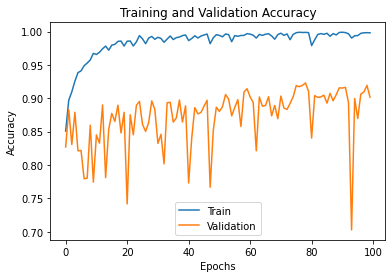

In [34]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [35]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [36]:
base_inception.save("./inception_base")

INFO:tensorflow:Assets written to: ./inception_base/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.87      0.93      0.90       437
      forest       0.97      0.99      0.98       474
     glacier       0.91      0.79      0.85       553
    mountain       0.79      0.92      0.85       525
         sea       0.97      0.92      0.94       510
      street       0.92      0.88      0.90       501

    accuracy                           0.90      3000
   macro avg       0.91      0.91      0.90      3000
weighted avg       0.91      0.90      0.90      3000



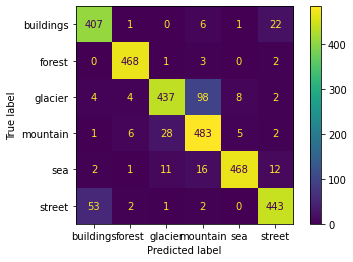

In [37]:
generate_report(base_inception, test_ds, class_names)

### Feature Extract

In [38]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fe_inception = get_inceptionv3(img_shape)
    fe_inception.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = fe_inception.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 31s 101ms/step - loss: 0.6276 - accuracy: 0.7747 - val_loss: 0.2691 - val_accuracy: 0.8970
Epoch 2/100
220/220 [==============================] - 19s 86ms/step - loss: 0.2509 - accuracy: 0.9051 - val_loss: 0.2365 - val_accuracy: 0.9060
Epoch 3/100
220/220 [==============================] - 19s 86ms/step - loss: 0.2188 - accuracy: 0.9176 - val_loss: 0.2283 - val_accuracy: 0.9110
Epoch 4/100
220/220 [==============================] - 19s 86ms/step - loss: 0.2017 - accuracy: 0.9248 - val_loss: 0.2393 - val_accuracy: 0.9050
Epoch 5/100
220/220 [==============================] - 19s 86ms/step - loss: 0.1942 - accuracy: 0.9284 - val_loss: 0.2258 - val_accuracy: 0.9123
Epoch 6/100
220/220 [==============================] - 19s 86ms/step - loss: 0.1830 - accuracy: 0.9332 - val_loss: 0.2226 - v

Final Train Accuracy:  0.9833261966705322
Final Validation Accuracy:  0.8966666460037231


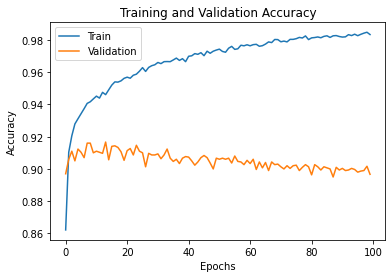

In [39]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [40]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [41]:
fe_inception.save("./inception_fe")

INFO:tensorflow:Assets written to: ./inception_fe/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.86      0.90      0.88       437
      forest       0.99      0.99      0.99       474
     glacier       0.91      0.77      0.83       553
    mountain       0.80      0.89      0.84       525
         sea       0.92      0.97      0.94       510
      street       0.92      0.89      0.90       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



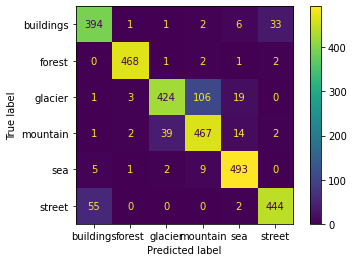

In [42]:
generate_report(fe_inception, test_ds, class_names)

### Finetune

In [43]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    f_inception = get_inceptionv3(img_shape, finetune = True)
    f_inception.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(lr=0.0001), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = f_inception.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 111s 327ms/step - loss: 0.4768 - accuracy: 0.8260 - val_loss: 0.1976 - val_accuracy: 0.9320
Epoch 2/100
220/220 [==============================] - 69s 312ms/step - loss: 0.1391 - accuracy: 0.9513 - val_loss: 0.2885 - val_accuracy: 0.9110
Epoch 3/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0689 - accuracy: 0.9785 - val_loss: 0.2690 - val_accuracy: 0.9273
Epoch 4/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0564 - accuracy: 0.9800 - val_loss: 0.3560 - val_accuracy: 0.9150
Epoch 5/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0450 - accuracy: 0.9847 - val_loss: 0.3141 - val_accuracy: 0.9233
Epoch 6/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0327 - accuracy: 0.9892 - val_loss: 0.29

Epoch 56/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.4137 - val_accuracy: 0.9347
Epoch 57/100
220/220 [==============================] - 69s 313ms/step - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.5123 - val_accuracy: 0.9180
Epoch 58/100
220/220 [==============================] - 69s 313ms/step - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.4360 - val_accuracy: 0.9190
Epoch 59/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0095 - accuracy: 0.9964 - val_loss: 0.3831 - val_accuracy: 0.9287
Epoch 60/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.4238 - val_accuracy: 0.9270
Epoch 61/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0164 - accuracy: 0.9952 - val_loss: 0.3715 - val_accuracy: 0.9240
Epoch 62/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0

Final Train Accuracy:  0.997933566570282
Final Validation Accuracy:  0.925000011920929


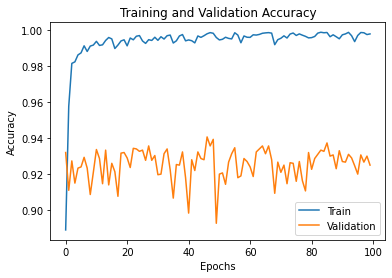

In [44]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [45]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [46]:
f_inception.save("./inception_f")

INFO:tensorflow:Assets written to: ./inception_f/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.90      0.93      0.91       437
      forest       0.97      1.00      0.98       474
     glacier       0.91      0.88      0.89       553
    mountain       0.91      0.87      0.89       525
         sea       0.92      0.97      0.94       510
      street       0.95      0.91      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.92      0.93      0.92      3000



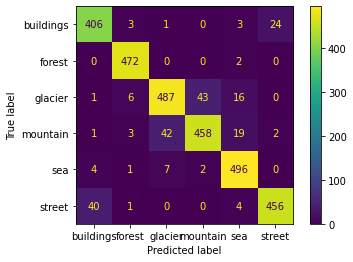

In [47]:
generate_report(f_inception, test_ds, class_names)

### Feature Extract + Finetune

In [48]:
EPOCHS = 50
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fef_inception = get_inceptionv3(img_shape)
    fef_inception.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

fe_start = time.time()
history = fef_inception.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
fe_total = time.time() - fe_start

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
220/220 [==============================] - 31s 101ms/step - loss: 0.6410 - accuracy: 0.7600 - val_loss: 0.2590 - val_accuracy: 0.9050
Epoch 2/50
220/220 [==============================] - 19s 85ms/step - loss: 0.2503 - accuracy: 0.9040 - val_loss: 0.2420 - val_accuracy: 0.9077
Epoch 3/50
220/220 [==============================] - 19s 86ms/step - loss: 0.2187 - accuracy: 0.9178 - val_loss: 0.2519 - val_accuracy: 0.9027
Epoch 4/50
220/220 [==============================] - 19s 86ms/step - loss: 0.2069 - accuracy: 0.9216 - val_loss: 0.2347 - val_accuracy: 0.9097
Epoch 5/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1888 - accuracy: 0.9295 - val_loss: 0.2416 - val_accuracy: 0.9063
Epoch 6/50
220/220 [==============================] - 19s 85ms/step - loss: 0.1845 - accuracy: 0.9310 - val_loss: 0.2277 - val_acc

Final Train Accuracy:  0.9712127447128296
Final Validation Accuracy:  0.906333327293396


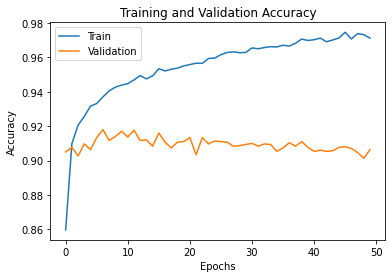

In [49]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [50]:
with strategy.scope():
    fef_inception.layers[3].trainable = True #mark it as trainable
    fef_inception.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(lr=0.0001), #making minor adjustments to the network
                           metrics = ['accuracy'])
    
total_epochs = EPOCHS + EPOCHS

f_start = time.time()
history = fef_inception.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data = test_ds,
                             verbose=1)
f_total = time.time() - f_start
print("Total Time (Training): ", fe_total + f_total)

Epoch 50/100
220/220 [==============================] - 112s 328ms/step - loss: 0.5075 - accuracy: 0.8523 - val_loss: 0.2691 - val_accuracy: 0.9147
Epoch 51/100
220/220 [==============================] - 69s 311ms/step - loss: 0.1275 - accuracy: 0.9562 - val_loss: 0.3159 - val_accuracy: 0.9103
Epoch 52/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0652 - accuracy: 0.9779 - val_loss: 0.3101 - val_accuracy: 0.9160
Epoch 53/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.3411 - val_accuracy: 0.9167
Epoch 54/100
220/220 [==============================] - 69s 311ms/step - loss: 0.0508 - accuracy: 0.9833 - val_loss: 0.3802 - val_accuracy: 0.9173
Epoch 55/100
220/220 [==============================] - 69s 312ms/step - loss: 0.0418 - accuracy: 0.9864 - val_loss: 0.3541 - val_accuracy: 0.9197
Epoch 56/100
220/220 [==============================] - 69s 311ms/step - loss: 0.0477 - accuracy: 0.9819 - val_loss: 

Final Train Accuracy:  0.9952259063720703
Final Validation Accuracy:  0.9309999942779541


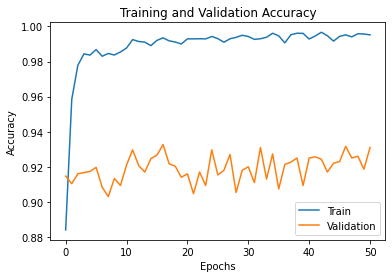

In [51]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

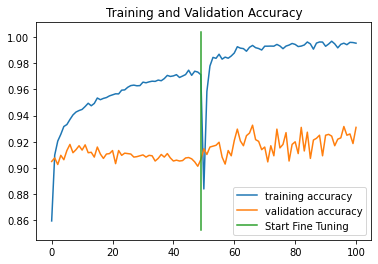

In [52]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
plot_train_and_val_acc(acc, val_acc, EPOCHS)

In [53]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [54]:
fef_inception.save("./inception_fef")

INFO:tensorflow:Assets written to: ./inception_fef/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.92      0.87      0.89       553
    mountain       0.89      0.89      0.89       525
         sea       0.93      0.98      0.96       510
      street       0.93      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



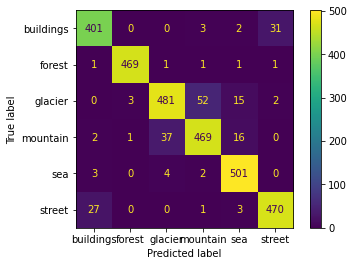

In [55]:
generate_report(fef_inception, test_ds, class_names)

## InceptionResNetV2

In [56]:
def get_inceptionResV2(input_shape, finetune = False, is_base = False):
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    
    base_model = None
    
    if is_base:
        base_model = tf.keras.applications.InceptionResNetV2(input_shape = input_shape,
                                                             include_top = False,
                                                             pooling = "avg")
    else:
        base_model = tf.keras.applications.InceptionResNetV2(input_shape = input_shape,
                                                             include_top = False,
                                                             weights = "imagenet",
                                                             pooling = "avg")
    base_model.trainable = finetune
    
    inputs = tf.keras.Input(shape = input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [57]:
#Test
my_model = get_inceptionResV2((256,256, 3))
print(my_model.layers[3].name)
#my_model.summary()

inception_resnet_v2


### Base Model

In [58]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_inceptionRes = get_inceptionResV2(img_shape, finetune = True, is_base = True)
    base_inceptionRes.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = base_inceptionRes.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 260s 770ms/step - loss: 0.4684 - accuracy: 0.8395 - val_loss: 2.4432 - val_accuracy: 0.3810
Epoch 2/100
220/220 [==============================] - 162s 733ms/step - loss: 0.2337 - accuracy: 0.9210 - val_loss: 0.2998 - val_accuracy: 0.8977
Epoch 3/100
220/220 [==============================] - 162s 734ms/step - loss: 0.1975 - accuracy: 0.9283 - val_loss: 1.5842 - val_accuracy: 0.7860
Epoch 4/100
220/220 [==============================] - 162s 734ms/step - loss: 0.1561 - accuracy: 0.9443 - val_loss: 0.4982 - val_accuracy: 0.8570
Epoch 5/100
220/220 [==============================] - 162s 733ms/step - loss: 0.1353 - accuracy: 0.9532 - val_loss: 1.0314 - val_accuracy: 0.7433
Epoch 6/100
220/220 [==============================] - 162s 732ms/step - loss: 0.1072 - accuracy: 0.9634 - val_loss:

Final Train Accuracy:  0.9957246780395508
Final Validation Accuracy:  0.8939999938011169


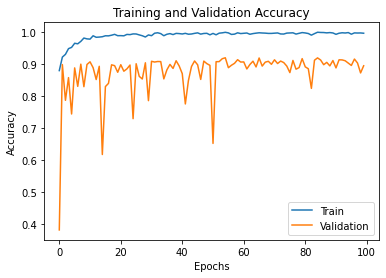

In [59]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [60]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [61]:
base_inceptionRes.save("./inceptionRes_base")

INFO:tensorflow:Assets written to: ./inceptionRes_base/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.83      0.92      0.87       437
      forest       0.99      0.97      0.98       474
     glacier       0.89      0.83      0.86       553
    mountain       0.80      0.92      0.85       525
         sea       0.93      0.94      0.93       510
      street       0.95      0.80      0.87       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.89      0.89      3000



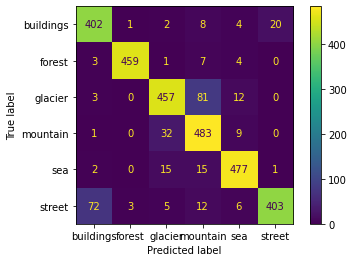

In [62]:
generate_report(base_inceptionRes, test_ds, class_names)

### Feature Extract

In [63]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fe_inceptionRes = get_inceptionResV2(img_shape)
    fe_inceptionRes.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])
    

start = time.time()
history = fe_inceptionRes.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 58s 152ms/step - loss: 0.5939 - accuracy: 0.7859 - val_loss: 0.2440 - val_accuracy: 0.9120
Epoch 2/100
220/220 [==============================] - 26s 118ms/step - loss: 0.2409 - accuracy: 0.9122 - val_loss: 0.2576 - val_accuracy: 0.8963
Epoch 3/100
220/220 [==============================] - 26s 118ms/step - loss: 0.2244 - accuracy: 0.9190 - val_loss: 0.2233 - val_accuracy: 0.9157
Epoch 4/100
220/220 [==============================] - 26s 118ms/step - loss: 0.2045 - accuracy: 0.9265 - val_loss: 0.2184 - val_accuracy: 0.9177
Epoch 5/100
220/220 [==============================] - 26s 118ms/step - loss: 0.2014 - accuracy: 0.9260 - val_loss: 0.2075 - val_accuracy: 0.9220
Epoch 6/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1933 - accuracy: 0.9269 - val_loss: 0.217

Epoch 56/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1075 - accuracy: 0.9605 - val_loss: 0.2283 - val_accuracy: 0.9237
Epoch 57/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1126 - accuracy: 0.9579 - val_loss: 0.2202 - val_accuracy: 0.9230
Epoch 58/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1083 - accuracy: 0.9595 - val_loss: 0.2324 - val_accuracy: 0.9187
Epoch 59/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1068 - accuracy: 0.9608 - val_loss: 0.2477 - val_accuracy: 0.9157
Epoch 60/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1147 - accuracy: 0.9557 - val_loss: 0.2281 - val_accuracy: 0.9213
Epoch 61/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1072 - accuracy: 0.9610 - val_loss: 0.2246 - val_accuracy: 0.9233
Epoch 62/100
220/220 [==============================] - 26s 118ms/step - loss: 0.1050 - accuracy: 0.9608 - val_loss: 0

Final Train Accuracy:  0.9700726866722107
Final Validation Accuracy:  0.9193333387374878


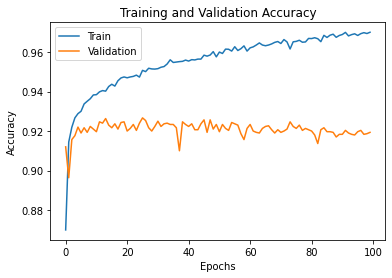

In [64]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [65]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [66]:
fe_inceptionRes.save("./inceptionRes_fe")

INFO:tensorflow:Assets written to: ./inceptionRes_fe/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.91      0.92      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.91      0.82      0.86       553
    mountain       0.85      0.91      0.88       525
         sea       0.94      0.97      0.95       510
      street       0.93      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



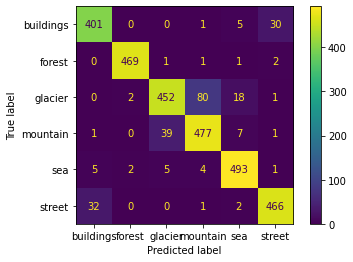

In [67]:
generate_report(fe_inceptionRes, test_ds, class_names)

### Finetune

In [68]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    f_inceptionRes = get_inceptionResV2(img_shape, finetune = True)
    f_inceptionRes.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(lr=0.0001), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = f_inceptionRes.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 266s 765ms/step - loss: 0.4384 - accuracy: 0.8487 - val_loss: 0.2147 - val_accuracy: 0.9200
Epoch 2/100
220/220 [==============================] - 161s 732ms/step - loss: 0.1207 - accuracy: 0.9570 - val_loss: 0.2546 - val_accuracy: 0.9223
Epoch 3/100
220/220 [==============================] - 162s 732ms/step - loss: 0.0570 - accuracy: 0.9824 - val_loss: 0.2602 - val_accuracy: 0.9317
Epoch 4/100
220/220 [==============================] - 161s 732ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.3002 - val_accuracy: 0.9210
Epoch 5/100
220/220 [==============================] - 162s 732ms/step - loss: 0.0317 - accuracy: 0.9883 - val_loss: 0.3062 - val_accuracy: 0.9270
Epoch 6/100
220/220 [==============================] - 161s 731ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss:

Final Train Accuracy:  0.9990023970603943
Final Validation Accuracy:  0.9309999942779541


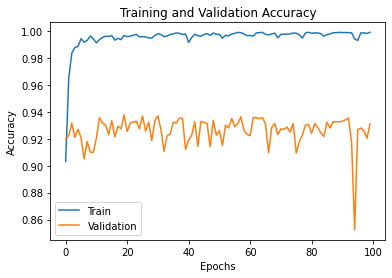

In [69]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [70]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [71]:
f_inceptionRes.save("./inceptionRes_f")

INFO:tensorflow:Assets written to: ./inceptionRes_f/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.89      0.88      0.89       553
    mountain       0.89      0.88      0.89       525
         sea       0.94      0.96      0.95       510
      street       0.94      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



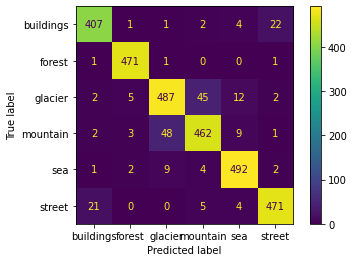

In [72]:
generate_report(f_inceptionRes, test_ds, class_names)

### Feature Extract + Finetune

In [73]:
EPOCHS = 50
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fef_inceptionRes = get_inceptionResV2(img_shape)
    fef_inceptionRes.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

fe_start = time.time()
history = fef_inceptionRes.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
fe_total = time.time() - fe_start

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
220/220 [==============================] - 50s 146ms/step - loss: 0.5808 - accuracy: 0.7939 - val_loss: 0.2415 - val_accuracy: 0.9127
Epoch 2/50
220/220 [==============================] - 26s 115ms/step - loss: 0.2390 - accuracy: 0.9103 - val_loss: 0.2277 - val_accuracy: 0.9143
Epoch 3/50
220/220 [==============================] - 26s 115ms/step - loss: 0.2209 - accuracy: 0.9169 - val_loss: 0.2234 - val_accuracy: 0.9157
Epoch 4/50
220/220 [==============================] - 26s 115ms/step - loss: 0.2040 - accuracy: 0.9236 - val_loss: 0.2261 - val_accuracy: 0.9153
Epoch 5/50
220/220 [==============================] - 26s 115ms/step - loss: 0.1994 - accuracy: 0.9262 - val_loss: 0.2058 - val_accuracy: 0.9207
Epoch 6/50
220/220 [==============================] - 26s 115ms/step - loss: 0.1898 - accuracy: 0.9290 - val_loss: 0.2110 - va

Final Train Accuracy:  0.9585292935371399
Final Validation Accuracy:  0.9233333468437195


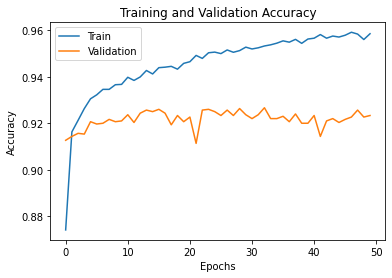

In [74]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [75]:
with strategy.scope():
    fef_inceptionRes.layers[3].trainable = True #mark it as trainable
    fef_inceptionRes.compile(loss = 'sparse_categorical_crossentropy',
                              optimizer = tf.keras.optimizers.Adam(lr=0.0001), #making minor adjustments to the network
                              metrics = ['accuracy'])
    
total_epochs = EPOCHS + EPOCHS

f_start = time.time()
history = fef_inceptionRes.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data = test_ds,
                             verbose=1)
f_total = time.time() - f_start
print("Total Time (Training): ", fe_total + f_total)

Epoch 50/100
220/220 [==============================] - 268s 764ms/step - loss: 0.3595 - accuracy: 0.8795 - val_loss: 0.2055 - val_accuracy: 0.9237
Epoch 51/100
220/220 [==============================] - 161s 731ms/step - loss: 0.1022 - accuracy: 0.9624 - val_loss: 0.2275 - val_accuracy: 0.9260
Epoch 52/100
220/220 [==============================] - 161s 732ms/step - loss: 0.0413 - accuracy: 0.9871 - val_loss: 0.3242 - val_accuracy: 0.9227
Epoch 53/100
220/220 [==============================] - 162s 732ms/step - loss: 0.0285 - accuracy: 0.9917 - val_loss: 0.3307 - val_accuracy: 0.9260
Epoch 54/100
220/220 [==============================] - 161s 732ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.3171 - val_accuracy: 0.9257
Epoch 55/100
220/220 [==============================] - 161s 731ms/step - loss: 0.0257 - accuracy: 0.9923 - val_loss: 0.5690 - val_accuracy: 0.8910
Epoch 56/100
220/220 [==============================] - 161s 731ms/step - loss: 0.0361 - accuracy: 0.9866 - val_

Final Train Accuracy:  0.9968647360801697
Final Validation Accuracy:  0.9210000038146973


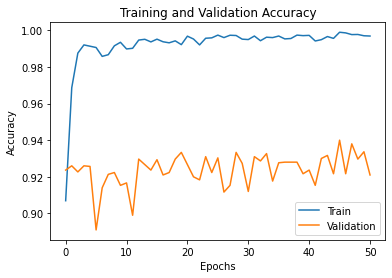

In [76]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

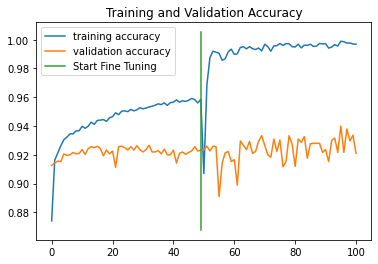

In [77]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
plot_train_and_val_acc(acc, val_acc, EPOCHS)

In [78]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [79]:
fef_inceptionRes.save("./inceptionRes_fef")

INFO:tensorflow:Assets written to: ./inceptionRes_fef/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.96      0.84      0.89       437
      forest       0.98      1.00      0.99       474
     glacier       0.91      0.85      0.88       553
    mountain       0.84      0.93      0.88       525
         sea       0.97      0.95      0.96       510
      street       0.88      0.97      0.92       501

    accuracy                           0.92      3000
   macro avg       0.93      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



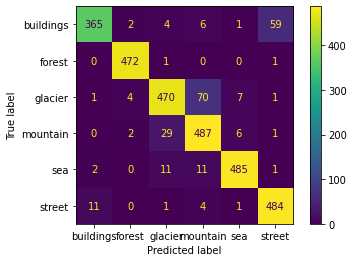

In [80]:
generate_report(fef_inceptionRes, test_ds, class_names)

## VGG16

In [93]:
def get_VGG16(input_shape, finetune = False, is_base = False):
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    
    base_model = None
    
    if is_base:
        base_model = tf.keras.applications.VGG16(input_shape = input_shape,
                                                             include_top = False,
                                                             pooling = "avg")
    else:
        base_model = tf.keras.applications.VGG16(input_shape = input_shape,
                                                             include_top = False,
                                                             weights = "imagenet",
                                                             pooling = "avg")
    base_model.trainable = finetune
    
    inputs = tf.keras.Input(shape = input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

### Base Model

In [94]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_vgg = get_VGG16(img_shape, finetune = True, is_base = True)
    base_vgg.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = base_vgg.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/100
220/220 [==============================] - 67s 269ms/step - loss: 3.7665 - accuracy: 0.2590 - val_loss: 1.0840 - val_accuracy: 0.5107
Epoch 2/100
220/220 [==============================] - 54s 245ms/step - loss: 1.0050 - accuracy: 0.5927 - val_loss: 0.8690 - val_accuracy: 0.6417
Epoch 3/100
220/220 [==============================] - 55s 246ms/step - loss: 0.8065 - accuracy: 0.6848 - val_loss: 0.6853 - val_accuracy: 0.7413
Epoch 4/100
220/220 [==============================] - 54s 245ms/step - loss: 0.6407 - accuracy: 0.7615 - val_loss: 0.5112 - val_accuracy: 0.8193
Epoch 5/100
220/220 [==============================] - 55s 246ms/step - loss: 0.5478 - accuracy: 0.8037 - val_loss: 0.5668 - val_accuracy: 0.8043
Epoch 6/100
220/220 [==============================] - 5

Final Train Accuracy:  0.9613082408905029
Final Validation Accuracy:  0.8446666598320007


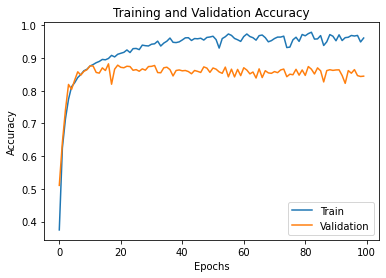

In [95]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [96]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [97]:
base_vgg.save("./vgg_base")

INFO:tensorflow:Assets written to: ./vgg_base/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.82      0.86      0.84       437
      forest       0.95      0.97      0.96       474
     glacier       0.88      0.68      0.76       553
    mountain       0.77      0.83      0.80       525
         sea       0.81      0.91      0.86       510
      street       0.86      0.84      0.85       501

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.84      0.84      3000



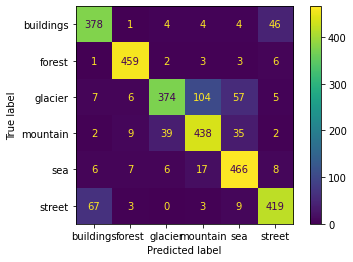

In [98]:
generate_report(base_vgg, test_ds, class_names)

### Feature Extract

In [99]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fe_vgg = get_VGG16(img_shape)
    fe_vgg.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = fe_vgg.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 24s 94ms/step - loss: 1.5910 - accuracy: 0.5895 - val_loss: 0.3687 - val_accuracy: 0.8733
Epoch 2/100
220/220 [==============================] - 20s 88ms/step - loss: 0.3044 - accuracy: 0.8948 - val_loss: 0.2999 - val_accuracy: 0.8963
Epoch 3/100
220/220 [==============================] - 20s 88ms/step - loss: 0.2467 - accuracy: 0.9124 - val_loss: 0.2803 - val_accuracy: 0.9047
Epoch 4/100
220/220 [==============================] - 20s 88ms/step - loss: 0.2223 - accuracy: 0.9197 - val_loss: 0.2686 - val_accuracy: 0.9103
Epoch 5/100
220/220 [==============================] - 20s 88ms/step - loss: 0.2038 - accuracy: 0.9261 - val_loss: 0.2680 - val_accuracy: 0.9077
Epoch 6/100
220/220 [==============================] - 20s 88ms/step - loss: 0.1947 - accuracy: 0.9306 - val_loss: 0.2636 - va

Final Train Accuracy:  0.9533988833427429
Final Validation Accuracy:  0.8943333625793457


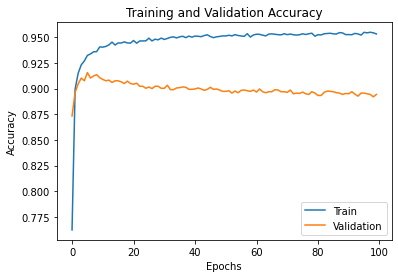

In [100]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [101]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [102]:
fe_vgg.save("./vgg_fe")

INFO:tensorflow:Assets written to: ./vgg_fe/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.91      0.87      0.89       437
      forest       0.97      0.99      0.98       474
     glacier       0.84      0.81      0.82       553
    mountain       0.82      0.84      0.83       525
         sea       0.94      0.94      0.94       510
      street       0.89      0.92      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



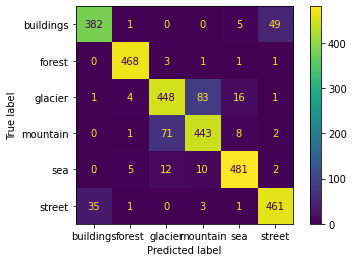

In [103]:
generate_report(fe_vgg, test_ds, class_names)

### Finetune

In [104]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    f_vgg = get_VGG16(img_shape, finetune = True)
    f_vgg.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = f_vgg.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 60s 253ms/step - loss: 4.2689 - accuracy: 0.2183 - val_loss: 1.3942 - val_accuracy: 0.3753
Epoch 2/100
220/220 [==============================] - 55s 247ms/step - loss: 1.6737 - accuracy: 0.3320 - val_loss: 1.3299 - val_accuracy: 0.4343
Epoch 3/100
220/220 [==============================] - 55s 248ms/step - loss: 1.2079 - accuracy: 0.5041 - val_loss: 0.9520 - val_accuracy: 0.6207
Epoch 4/100
220/220 [==============================] - 55s 248ms/step - loss: 0.8924 - accuracy: 0.6539 - val_loss: 0.8168 - val_accuracy: 0.6847
Epoch 5/100
220/220 [==============================] - 55s 248ms/step - loss: 0.7587 - accuracy: 0.7181 - val_loss: 0.7052 - val_accuracy: 0.7577
Epoch 6/100
220/220 [==============================] - 55s 247ms/step - loss: 0.5908 - accuracy: 0.7874 - val_loss: 0.621

Epoch 56/100
220/220 [==============================] - 55s 247ms/step - loss: 0.0910 - accuracy: 0.9684 - val_loss: 0.7024 - val_accuracy: 0.8527
Epoch 57/100
220/220 [==============================] - 55s 248ms/step - loss: 0.0988 - accuracy: 0.9650 - val_loss: 0.6188 - val_accuracy: 0.8543
Epoch 58/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1346 - accuracy: 0.9508 - val_loss: 0.6244 - val_accuracy: 0.8613
Epoch 59/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1222 - accuracy: 0.9629 - val_loss: 0.6322 - val_accuracy: 0.8623
Epoch 60/100
220/220 [==============================] - 55s 248ms/step - loss: 0.1332 - accuracy: 0.9527 - val_loss: 0.7145 - val_accuracy: 0.8430
Epoch 61/100
220/220 [==============================] - 55s 248ms/step - loss: 0.2826 - accuracy: 0.9116 - val_loss: 0.6588 - val_accuracy: 0.8540
Epoch 62/100
220/220 [==============================] - 55s 247ms/step - loss: 0.0906 - accuracy: 0.9698 - val_loss: 0

Final Train Accuracy:  0.9641584753990173
Final Validation Accuracy:  0.8506666421890259


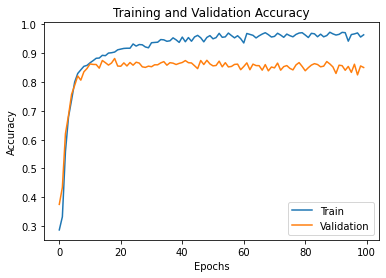

In [105]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [106]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [107]:
f_vgg.save("./vgg_f")

INFO:tensorflow:Assets written to: ./vgg_f/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.83      0.86      0.84       437
      forest       0.94      0.98      0.96       474
     glacier       0.86      0.72      0.78       553
    mountain       0.78      0.81      0.79       525
         sea       0.83      0.94      0.88       510
      street       0.88      0.83      0.86       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



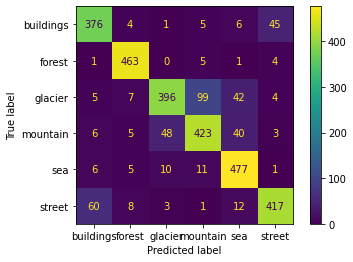

In [108]:
generate_report(f_vgg, test_ds, class_names)

### Feature Extract + Finetune

In [109]:
EPOCHS = 50
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fef_vgg = get_VGG16(img_shape)
    fef_vgg.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

fe_start = time.time()
history = fef_vgg.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
fe_total = time.time() - fe_start

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
220/220 [==============================] - 24s 94ms/step - loss: 1.5504 - accuracy: 0.6098 - val_loss: 0.3915 - val_accuracy: 0.8813
Epoch 2/50
220/220 [==============================] - 20s 87ms/step - loss: 0.3196 - accuracy: 0.8939 - val_loss: 0.3223 - val_accuracy: 0.8970
Epoch 3/50
220/220 [==============================] - 20s 87ms/step - loss: 0.2595 - accuracy: 0.9109 - val_loss: 0.3061 - val_accuracy: 0.9013
Epoch 4/50
220/220 [==============================] - 20s 87ms/step - loss: 0.2306 - accuracy: 0.9222 - val_loss: 0.2835 - val_accuracy: 0.9050
Epoch 5/50
220/220 [==============================] - 20s 88ms/step - loss: 0.2110 - accuracy: 0.9245 - val_loss: 0.2826 - val_accuracy: 0.9053
Epoch 6/50
220/220 [==============================] - 20s 88ms/step - loss: 0.1991 - accuracy: 0.9297 - val_loss: 0.2818 - val_accu

Final Train Accuracy:  0.9528288245201111
Final Validation Accuracy:  0.9016666412353516


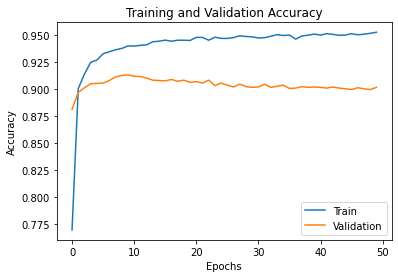

In [110]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [111]:
with strategy.scope():
    fef_vgg.layers[3].trainable = True #mark it as trainable
    fef_vgg.compile(loss = 'sparse_categorical_crossentropy',
                              optimizer = tf.keras.optimizers.Adam(lr=0.0001), #making minor adjustments to the network
                              metrics = ['accuracy'])
    
total_epochs = EPOCHS + EPOCHS

f_start = time.time()
history = fef_vgg.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data = test_ds,
                             verbose=1)
f_total = time.time() - f_start
print("Total Time (Training): ", fe_total + f_total)

Epoch 50/100
220/220 [==============================] - 60s 254ms/step - loss: 0.8276 - accuracy: 0.8156 - val_loss: 0.3445 - val_accuracy: 0.8787
Epoch 51/100
220/220 [==============================] - 55s 247ms/step - loss: 0.2550 - accuracy: 0.9090 - val_loss: 0.2919 - val_accuracy: 0.9040
Epoch 52/100
220/220 [==============================] - 55s 248ms/step - loss: 0.1965 - accuracy: 0.9273 - val_loss: 0.2513 - val_accuracy: 0.9190
Epoch 53/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1514 - accuracy: 0.9450 - val_loss: 0.3393 - val_accuracy: 0.8883
Epoch 54/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1565 - accuracy: 0.9436 - val_loss: 0.2592 - val_accuracy: 0.9247
Epoch 55/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1136 - accuracy: 0.9586 - val_loss: 0.2650 - val_accuracy: 0.9197
Epoch 56/100
220/220 [==============================] - 55s 247ms/step - loss: 0.1113 - accuracy: 0.9602 - val_loss: 0

Final Train Accuracy:  0.9902380108833313
Final Validation Accuracy:  0.9113333225250244


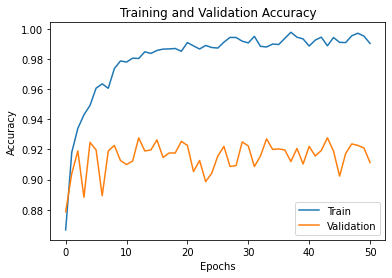

In [112]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

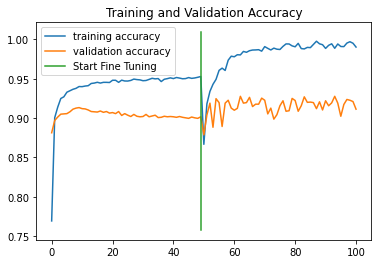

In [113]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
plot_train_and_val_acc(acc, val_acc, EPOCHS)

In [114]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [115]:
fef_vgg.save("./vgg_fef")

INFO:tensorflow:Assets written to: ./vgg_fef/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.88      0.93      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.88      0.84      0.86       553
    mountain       0.83      0.92      0.87       525
         sea       0.97      0.91      0.94       510
      street       0.94      0.89      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



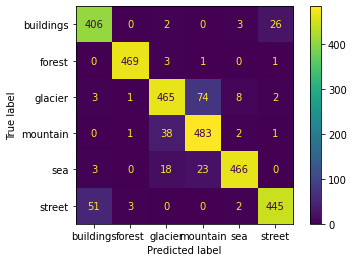

In [116]:
generate_report(fef_vgg, test_ds, class_names)

## ResNet50

In [117]:
def get_resnet50(input_shape, finetune = False, is_base = False):
    preprocess_input = tf.keras.applications.resnet.preprocess_input
    
    base_model = None
    
    if is_base:
        base_model = tf.keras.applications.ResNet50(input_shape = input_shape,
                                                             include_top = False,
                                                             pooling = "avg")
    else:
        base_model = tf.keras.applications.ResNet50(input_shape = input_shape,
                                                             include_top = False,
                                                             weights = "imagenet",
                                                             pooling = "avg")
    base_model.trainable = finetune
    
    inputs = tf.keras.Input(shape = input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

### Base Model

In [118]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_res = get_resnet50(img_shape, finetune = True, is_base = True)
    base_res.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = base_res.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 88s 277ms/step - loss: 0.6812 - accuracy: 0.7748 - val_loss: 0.9767 - val_accuracy: 0.7233
Epoch 2/100
220/220 [==============================] - 58s 260ms/step - loss: 0.3078 - accuracy: 0.8926 - val_loss: 0.5623 - val_accuracy: 0.8083
Epoch 3/100
220/220 [==============================] - 58s 260ms/step - loss: 0.2502 - accuracy: 0.9103 - val_loss: 0.5566 - val_accuracy: 0.8030
Epoch 4/100
220/220 [==============================] - 58s 260ms/step - loss: 0.1959 - accuracy: 0.9318 - val_loss: 0.4694 - val_accuracy: 0.8417
Epoch 5/100
220/220 [==============================] - 58s 260ms/step - loss: 0.1528 - accuracy: 0.9464 - val_loss: 0.4761 - val_accuracy: 0.8567
Epoch 6/100
220/220 [==============================] - 58s 260ms/step - loss: 0.1473 - accuracy: 0.9484 - val_loss: 1.448

Epoch 56/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0521 - accuracy: 0.9841 - val_loss: 0.9291 - val_accuracy: 0.7947
Epoch 57/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0336 - accuracy: 0.9884 - val_loss: 0.5860 - val_accuracy: 0.8810
Epoch 58/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.5474 - val_accuracy: 0.8997
Epoch 59/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.5090 - val_accuracy: 0.9007
Epoch 60/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.5502 - val_accuracy: 0.8990
Epoch 61/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.6632 - val_accuracy: 0.8813
Epoch 62/100
220/220 [==============================] - 58s 261ms/step - loss: 0.0177 - accuracy: 0.9938 - val_loss: 0

Final Train Accuracy:  0.9970072507858276
Final Validation Accuracy:  0.8999999761581421


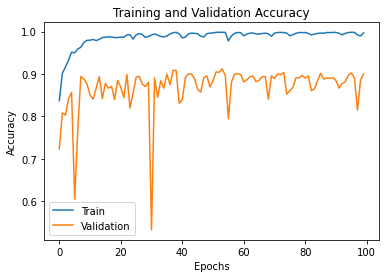

In [119]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [120]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [121]:
base_res.save("./res_base")

INFO:tensorflow:Assets written to: ./res_base/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.89      0.89      0.89       437
      forest       0.95      0.99      0.97       474
     glacier       0.88      0.81      0.85       553
    mountain       0.84      0.87      0.86       525
         sea       0.91      0.94      0.92       510
      street       0.92      0.90      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



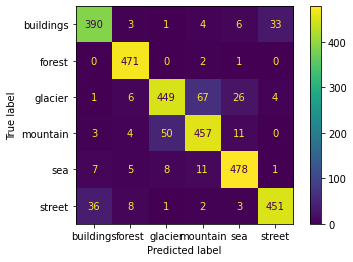

In [122]:
generate_report(base_res, test_ds, class_names)

### Feature Extract

In [123]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fe_res = get_resnet50(img_shape)
    fe_res.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = fe_res.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 29s 100ms/step - loss: 0.4993 - accuracy: 0.8222 - val_loss: 0.2247 - val_accuracy: 0.9183
Epoch 2/100
220/220 [==============================] - 20s 88ms/step - loss: 0.1853 - accuracy: 0.9320 - val_loss: 0.2099 - val_accuracy: 0.9213
Epoch 3/100
220/220 [==============================] - 20s 87ms/step - loss: 0.1590 - accuracy: 0.9405 - val_loss: 0.2043 - val_accuracy: 0.9233
Epoch 4/100
220/220 [==============================] - 19s 87ms/step - loss: 0.1422 - accuracy: 0.9481 - val_loss: 0.1899 - val_accuracy: 0.9300
Epoch 5/100
220/220 [==============================] - 20s 88ms/step - loss: 0.1320 - accuracy: 0.9515 - val_loss: 0.2014 - val_accuracy: 0.9283
Epoch 6/100
220/220 [==============================] - 20s 88ms/step - loss: 0.1240 - accuracy: 0.9533 - val_loss: 0.2198 - v

Final Train Accuracy:  0.9975060820579529
Final Validation Accuracy:  0.92166668176651


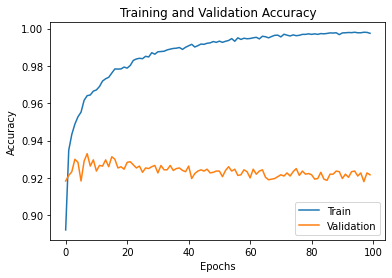

In [124]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [125]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [126]:
fe_res.save("./res_fe")

INFO:tensorflow:Assets written to: ./res_fe/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.90      0.93      0.92       437
      forest       0.99      1.00      0.99       474
     glacier       0.87      0.85      0.86       553
    mountain       0.87      0.87      0.87       525
         sea       0.95      0.98      0.97       510
      street       0.95      0.92      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



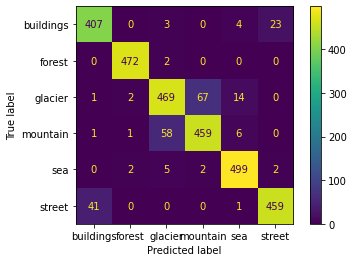

In [127]:
generate_report(fe_res, test_ds, class_names)

### Finetune

In [128]:
EPOCHS = 100
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    f_res = get_resnet50(img_shape, finetune = True)
    f_res.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

start = time.time()
history = f_res.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
total = time.time() - start
print("Total Time (Training): ", total)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
220/220 [==============================] - 85s 272ms/step - loss: 0.6900 - accuracy: 0.7871 - val_loss: 0.6990 - val_accuracy: 0.7700
Epoch 2/100
220/220 [==============================] - 57s 259ms/step - loss: 0.2890 - accuracy: 0.9023 - val_loss: 0.8011 - val_accuracy: 0.7653
Epoch 3/100
220/220 [==============================] - 57s 259ms/step - loss: 0.2437 - accuracy: 0.9150 - val_loss: 0.7195 - val_accuracy: 0.7817
Epoch 4/100
220/220 [==============================] - 57s 259ms/step - loss: 0.2078 - accuracy: 0.9246 - val_loss: 0.6706 - val_accuracy: 0.7980
Epoch 5/100
220/220 [==============================] - 57s 259ms/step - loss: 0.1643 - accuracy: 0.9404 - val_loss: 0.4177 - val_accuracy: 0.8627
Epoch 6/100
220/220 [==============================] - 58s 260ms/step - loss: 0.1410 - accuracy: 0.9481 - val_loss: 0.475

Epoch 56/100
220/220 [==============================] - 57s 259ms/step - loss: 0.0034 - accuracy: 0.9983 - val_loss: 0.5827 - val_accuracy: 0.9023
Epoch 57/100
220/220 [==============================] - 58s 259ms/step - loss: 0.0070 - accuracy: 0.9970 - val_loss: 1.0474 - val_accuracy: 0.8333
Epoch 58/100
220/220 [==============================] - 57s 259ms/step - loss: 0.0410 - accuracy: 0.9845 - val_loss: 0.5693 - val_accuracy: 0.8790
Epoch 59/100
220/220 [==============================] - 58s 259ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.7253 - val_accuracy: 0.8777
Epoch 60/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0300 - accuracy: 0.9896 - val_loss: 0.5533 - val_accuracy: 0.8783
Epoch 61/100
220/220 [==============================] - 57s 259ms/step - loss: 0.0235 - accuracy: 0.9917 - val_loss: 0.6503 - val_accuracy: 0.8970
Epoch 62/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0

Final Train Accuracy:  0.966153621673584
Final Validation Accuracy:  0.828000009059906


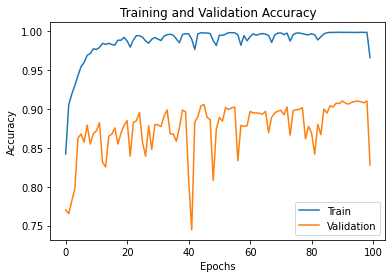

In [129]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

In [130]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [131]:
f_res.save("./res_f")

INFO:tensorflow:Assets written to: ./res_f/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.78      0.85      0.81       437
      forest       0.97      0.92      0.94       474
     glacier       0.77      0.72      0.75       553
    mountain       0.69      0.90      0.78       525
         sea       0.91      0.79      0.85       510
      street       0.93      0.81      0.86       501

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



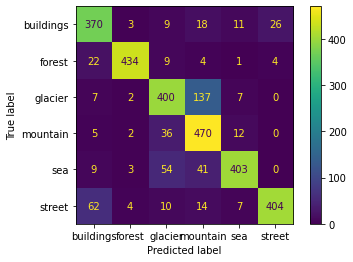

In [132]:
generate_report(f_res, test_ds, class_names)

### Feature Extract + Finetune

In [133]:
EPOCHS = 50
img_shape = (256, 256, 3)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    fef_res = get_resnet50(img_shape)
    fef_res.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(), #try different optimizer
                           metrics = ['accuracy'])

fe_start = time.time()
history = fef_res.fit(train_ds,
                             epochs=EPOCHS,
                             validation_data = test_ds,
                             verbose=1)
fe_total = time.time() - fe_start

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
220/220 [==============================] - 29s 98ms/step - loss: 0.5356 - accuracy: 0.8004 - val_loss: 0.2392 - val_accuracy: 0.9107
Epoch 2/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1887 - accuracy: 0.9296 - val_loss: 0.2001 - val_accuracy: 0.9293
Epoch 3/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1602 - accuracy: 0.9414 - val_loss: 0.1996 - val_accuracy: 0.9270
Epoch 4/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1470 - accuracy: 0.9461 - val_loss: 0.1930 - val_accuracy: 0.9300
Epoch 5/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1339 - accuracy: 0.9528 - val_loss: 0.1951 - val_accuracy: 0.9287
Epoch 6/50
220/220 [==============================] - 19s 86ms/step - loss: 0.1241 - accuracy: 0.9543 - val_loss: 0.1882 - val_accu

Final Train Accuracy:  0.9923756718635559
Final Validation Accuracy:  0.9259999990463257


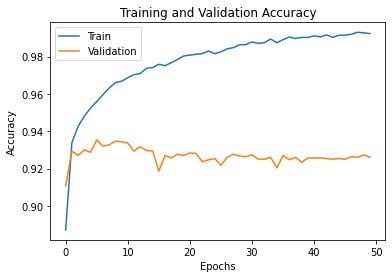

In [134]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [135]:
with strategy.scope():
    fef_res.layers[3].trainable = True #mark it as trainable
    fef_res.compile(loss = 'sparse_categorical_crossentropy',
                              optimizer = tf.keras.optimizers.Adam(lr=0.0001), #making minor adjustments to the network
                              metrics = ['accuracy'])
    
total_epochs = EPOCHS + EPOCHS

f_start = time.time()
history = fef_res.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data = test_ds,
                             verbose=1)
f_total = time.time() - f_start
print("Total Time (Training): ", fe_total + f_total)

Epoch 50/100
220/220 [==============================] - 84s 272ms/step - loss: 0.4725 - accuracy: 0.8984 - val_loss: 0.5638 - val_accuracy: 0.8877
Epoch 51/100
220/220 [==============================] - 58s 260ms/step - loss: 0.1618 - accuracy: 0.9587 - val_loss: 5.8232 - val_accuracy: 0.8497
Epoch 52/100
220/220 [==============================] - 58s 259ms/step - loss: 0.0688 - accuracy: 0.9778 - val_loss: 0.2929 - val_accuracy: 0.9290
Epoch 53/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0431 - accuracy: 0.9896 - val_loss: 0.2918 - val_accuracy: 0.9293
Epoch 54/100
220/220 [==============================] - 58s 260ms/step - loss: 0.0476 - accuracy: 0.9906 - val_loss: 0.4514 - val_accuracy: 0.9080
Epoch 55/100
220/220 [==============================] - 57s 259ms/step - loss: 0.0752 - accuracy: 0.9811 - val_loss: 0.3478 - val_accuracy: 0.9193
Epoch 56/100
220/220 [==============================] - 57s 259ms/step - loss: 0.0265 - accuracy: 0.9932 - val_loss: 4

Final Train Accuracy:  0.9974347949028015
Final Validation Accuracy:  0.890333354473114


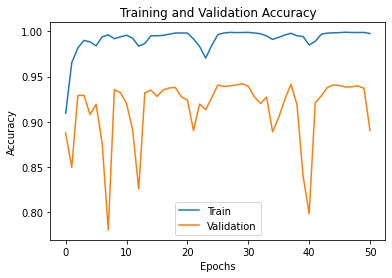

In [136]:
plot_model_acc(history.history['accuracy'], history.history['val_accuracy'])

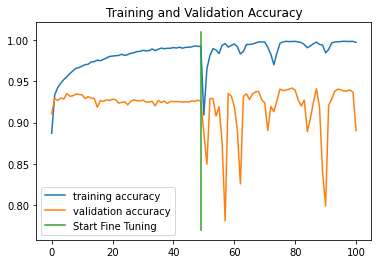

In [137]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
plot_train_and_val_acc(acc, val_acc, EPOCHS)

In [138]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [139]:
fef_res.save("./res_fef")

INFO:tensorflow:Assets written to: ./res_fef/assets


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
              precision    recall  f1-score   support

   buildings       0.87      0.93      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.76      0.92      0.83       553
    mountain       0.90      0.78      0.84       525
         sea       0.97      0.83      0.89       510
      street       0.92      0.92      0.92       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



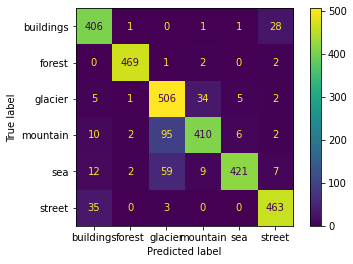

In [140]:
generate_report(fef_res, test_ds, class_names)

# Ensemble

In [150]:
from collections import defaultdict

def def_value():
    return 0

def get_majority(pred_list):
    num_rows = len(pred_list)
    num_cols = len(pred_list[0])
    result_pred = []
    for col in range(num_cols):
        class_mapper = defaultdict(def_value)
        for row in range(num_rows):
            current_pred = pred_list[row][col]
            class_mapper[current_pred]+=1
        current_max_val = -1
        current_max_key = None
        for k, v in class_mapper.items():
            if v > current_max_val:
                current_max_val = v
                current_max_key = k
        result_pred.append(current_max_key)
    return result_pred

def ensemble_predict(clf_list, test_ds, class_names):
    y_test = []
    y_pred = []
    for imgs, labels in test_ds.take(-1):
        actual_labels = labels.numpy()
        tmp_pred = []
        for clf in clf_list:
            pred = clf.predict_on_batch(imgs)
            pred = np.argmax(pred, axis=-1)
            pred = list(pred)
            tmp_pred.append(pred)
        actual_labels = list(actual_labels)
        pred = get_majority(tmp_pred)
        y_test+=actual_labels
        y_pred+=pred
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    #print("Actual: ", y_test[:20])
    #print("Pred: ", y_pred[:20])
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_cm(y_test, y_pred, class_names)

In [146]:
#Load all the model, make prediction, get majority

best_xception = tf.keras.models.load_model("./xception_f")
best_inception = tf.keras.models.load_model("./inception_fef")
best_inceptonRes = tf.keras.models.load_model("./inceptionRes_f")
best_vgg = tf.keras.models.load_model("./vgg_fef")
best_res = tf.keras.models.load_model("./res_fe")

In [147]:
clf_list = [best_xception, best_inception, best_inceptonRes, best_vgg, best_res]

              precision    recall  f1-score   support

   buildings       0.95      0.95      0.95       437
      forest       0.99      1.00      0.99       474
     glacier       0.93      0.89      0.91       553
    mountain       0.91      0.92      0.91       525
         sea       0.97      0.99      0.98       510
      street       0.96      0.96      0.96       501

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



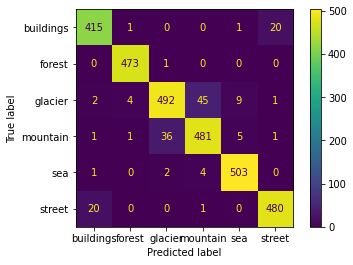

In [151]:
ensemble_predict(clf_list, test_ds, class_names)